In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [ ]:
def log_transform(df, cols):
    """
    Function for Log transformation

    Args:
        df (pandas dataframe): dataframe
        cols (list): list of columns to be transformed

    Returns:
        df (pandas dataframe): dataframe with log transformed columns
    
    """
    for col in cols[1:]: # skipping first column for index
        try:
            df[col] = np.log(1 + df[col])
        except:
            print(f'{col} unsuccessful')
    return df


## Outlier Removal 
def iqr_outlier_removal(df,attribute_list):
    """
    Function for IQR outlier removal

    Args:
        df (pandas dataframe): dataframe
        attribute_list (list): list of columns to be transformed    

    Returns:
        df (pandas dataframe): dataframe with IQR outlier removed
    
    """
    def identify_outlier(df,column):
        """Identify outlers via IQR"""
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3-Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        ls = df.index[(df[column]< lower) | (df[column]> upper)] #returns list of indices for outliers
        return ls 

    def extract_outliers (df, attribute_list):
        """Function to extract identifed outliers"""
        outliers = [] #Initialise empty list

        for column in df[attribute_list].columns:
            outliers.extend(identify_outlier(df,column))        
        return outliers
        
    def remove_outliers(df,ls):
        "Remove outliers"
        ls = sorted(set(ls))
        df = df.drop(ls)
        return df

    outlier_index_list = extract_outliers(df,attribute_list)
    outliers_removed = remove_outliers(df,outlier_index_list)
    return outliers_removed



In [75]:
df = pd.read_csv('../data/CC_GENERAL.csv')

In [51]:
df.isnull().sum().sort_values(ascending=False).head()


MINIMUM_PAYMENTS    313
CREDIT_LIMIT          1
CUST_ID               0
BALANCE               0
PRC_FULL_PAYMENT      0
dtype: int64

In [76]:
# Imputing missing values with mean

df.loc[(df['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=df['MINIMUM_PAYMENTS'].mean()
df.loc[(df['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=df['CREDIT_LIMIT'].mean()

In [74]:
df.isnull().sum().sort_values(ascending=False).head()


CUST_ID             0
BALANCE             0
PRC_FULL_PAYMENT    0
MINIMUM_PAYMENTS    0
PAYMENTS            0
dtype: int64

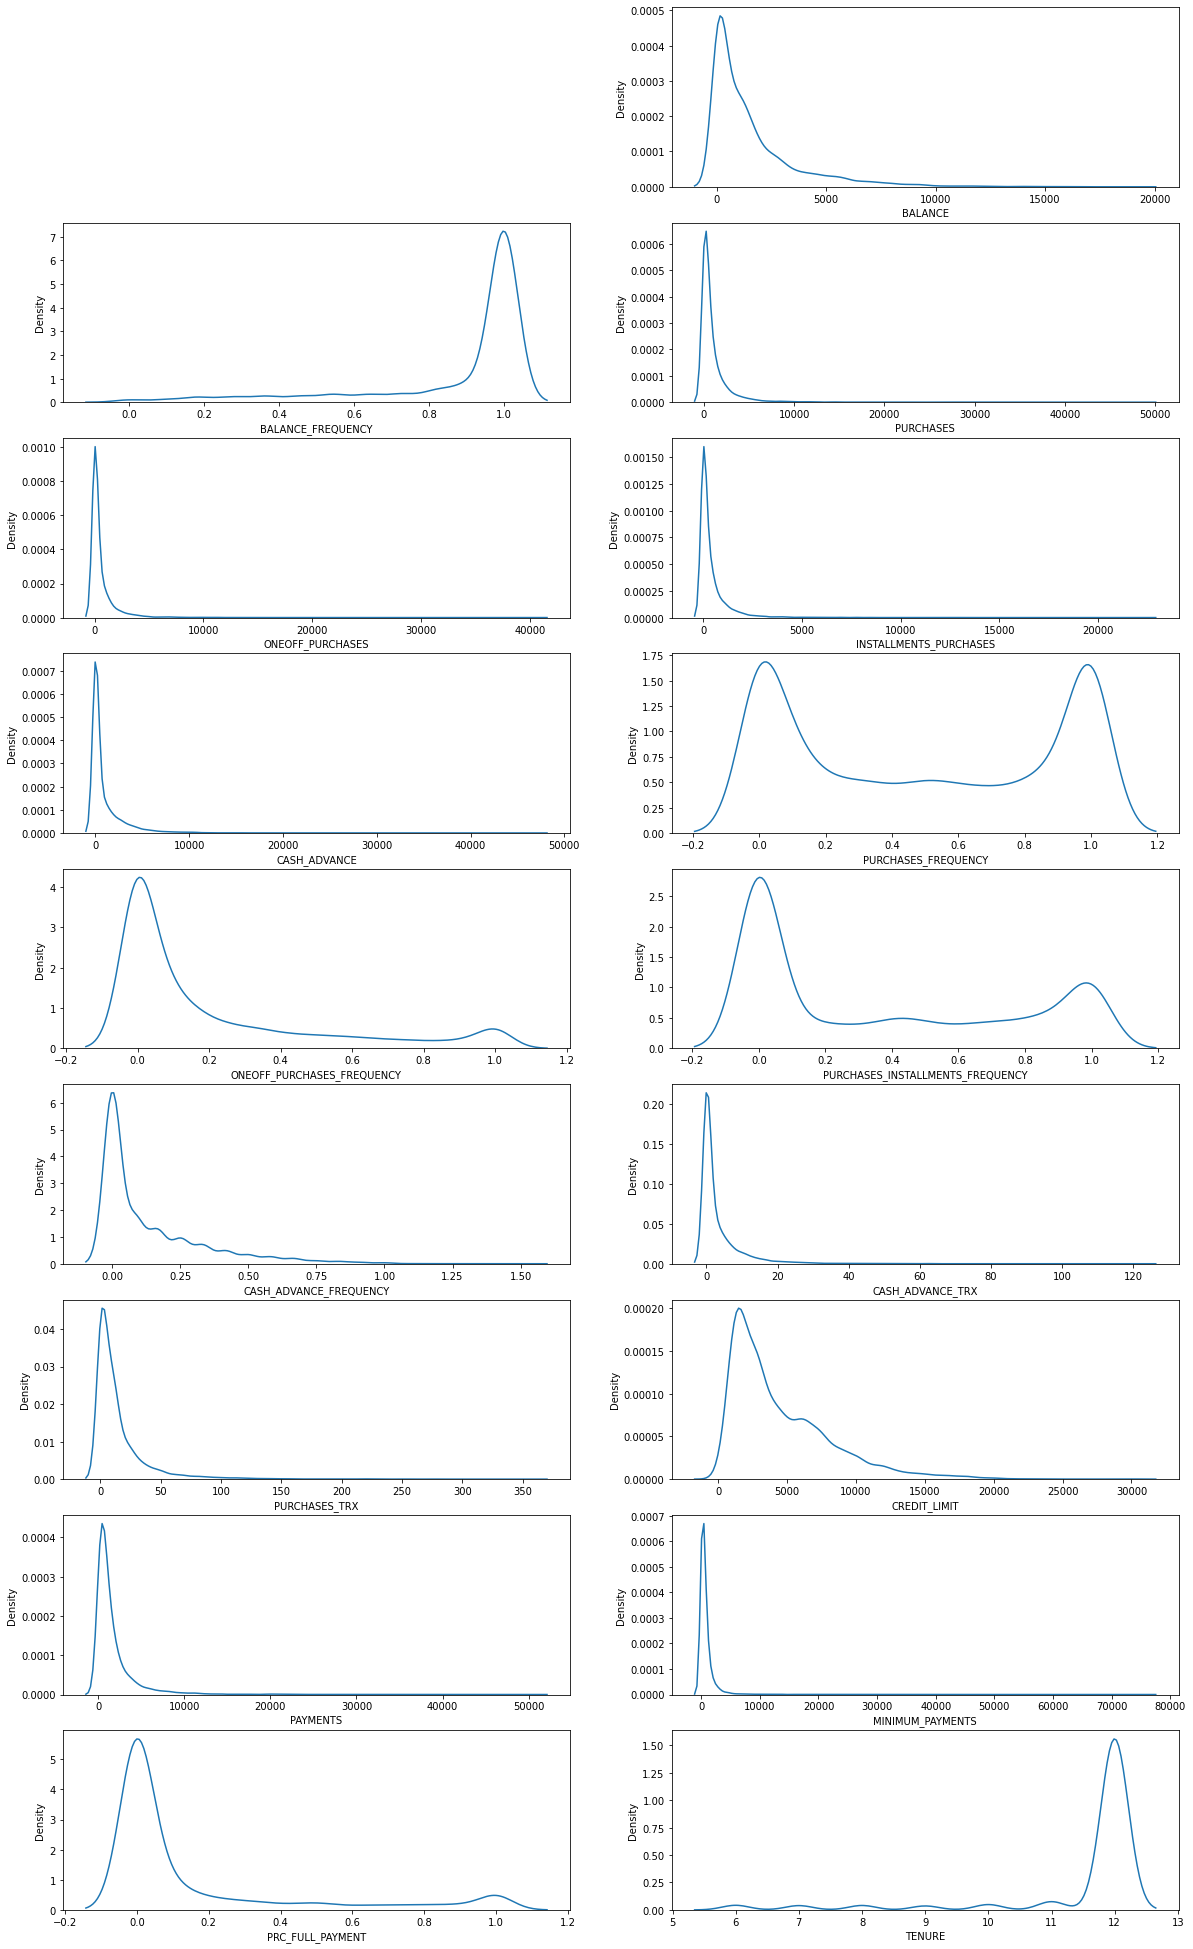

In [55]:
plt.figure(figsize=(20,35))
for i, col in enumerate(df.columns):
    if df[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

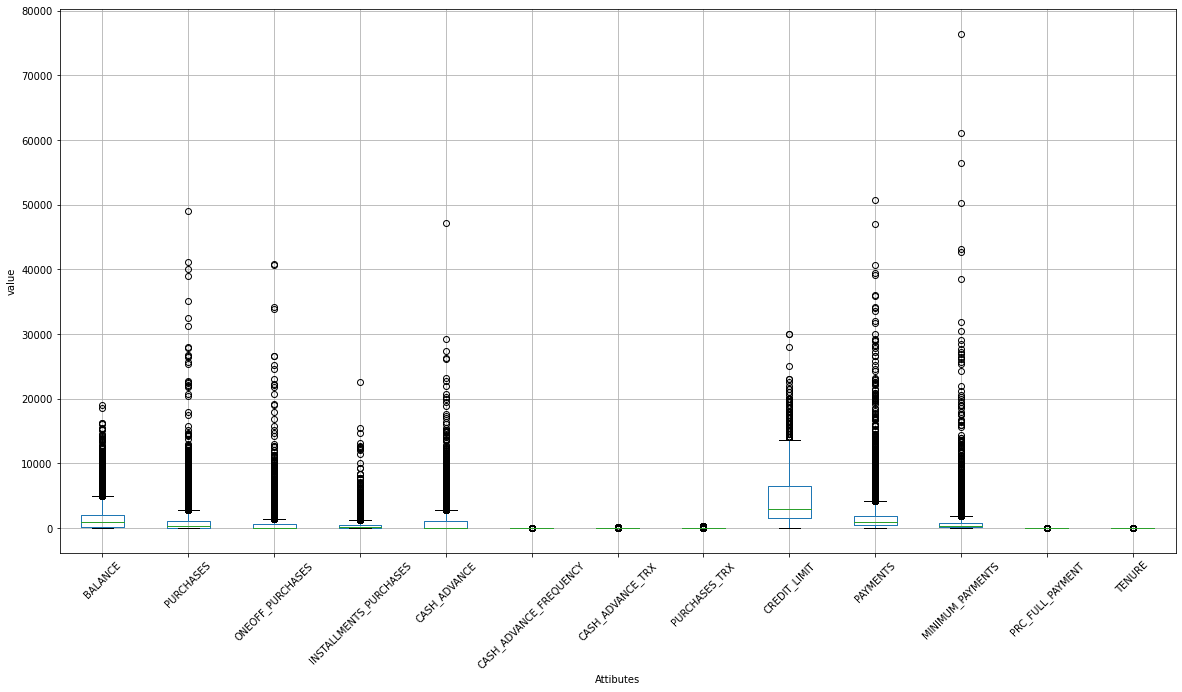

In [45]:
df.drop(['BALANCE_FREQUENCY','PURCHASES_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY'],axis=1).boxplot(figsize=(20,10));
plt.xticks(rotation=45);
plt.ylabel('value');
plt.xlabel('Attibutes');

In [103]:
# log transform
df_log_transformed = log_transform(df, list(df.columns))

In [57]:
# list of attributes to be removed
unwanted_ele = ['CUST_ID','BALANCE_FREQUENCY','PURCHASES_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY']
# 
attribute_list = [ele for ele in list(df.columns) if ele not in unwanted_ele]

# remove outliers
df_without_outliers = iqr_outlier_removal(df,attribute_list)


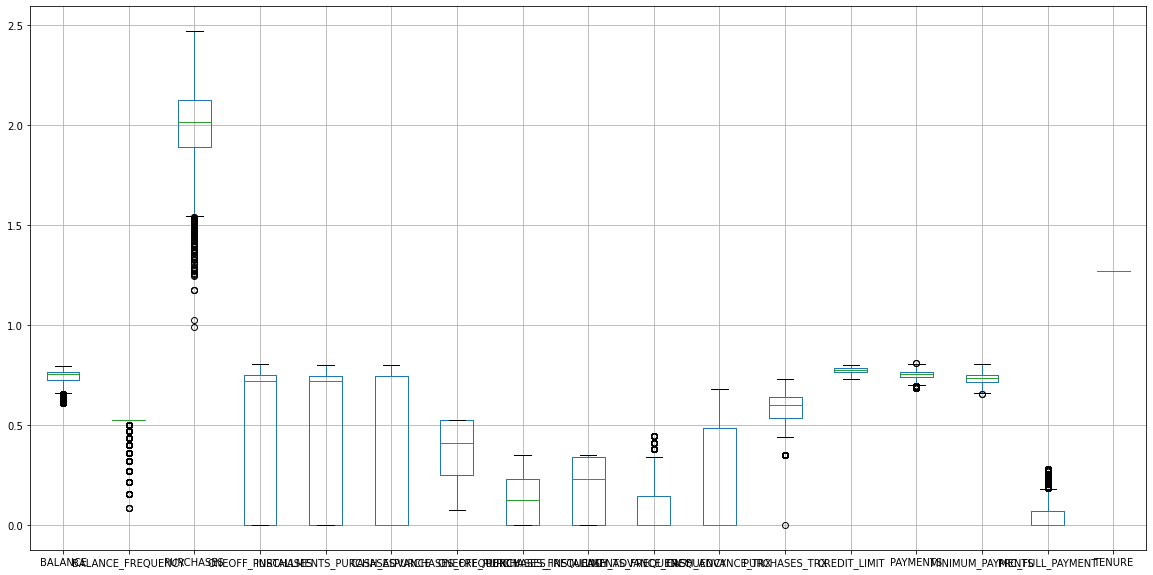

In [107]:
df_without_outliers.boxplot(figsize=(20,10));

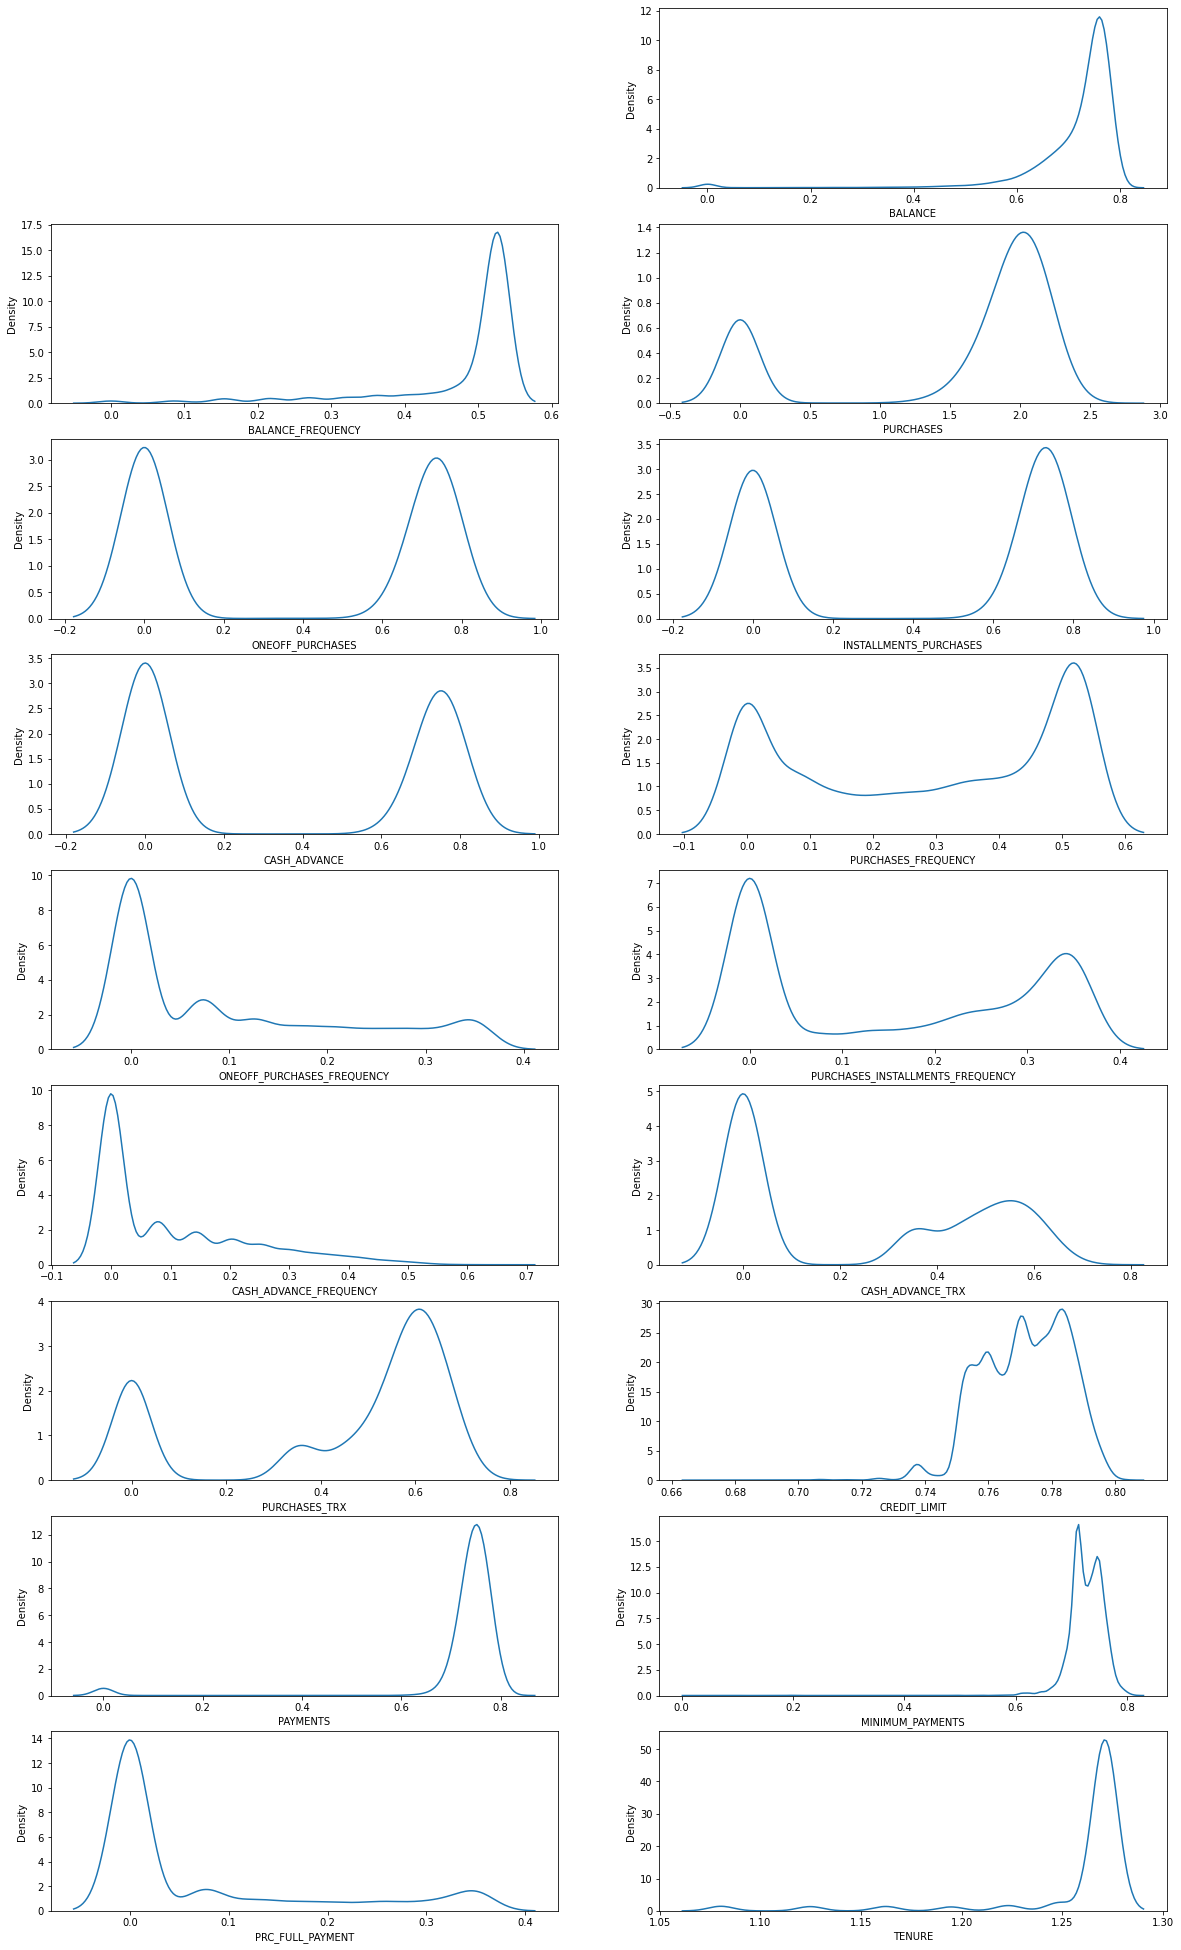

In [108]:
plt.figure(figsize=(20,35))
for i, col in enumerate(df_without_outliers.columns):
    if df_without_outliers[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df[col], ax=ax)
        plt.xlabel(col)
        
plt.show()